<a href="https://colab.research.google.com/github/S-Zorro/Tripod-Concealer/blob/main/tripod_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/milesial/Pytorch-UNet.git #need this for making masks

Cloning into 'Pytorch-UNet'...
remote: Enumerating objects: 608, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 608 (delta 128), reused 110 (delta 110), pack-reused 456
Receiving objects: 100% (608/608), 47.42 MiB | 16.11 MiB/s, done.
Resolving deltas: 100% (331/331), done.


In [ ]:
cd /content/Pytorch-UNet

/content/Pytorch-UNet


In [ ]:
from google.colab import drive #Mount your drive to load the weights
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import argparse
import logging
import os

import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

from utils.data_loading import BasicDataset
from unet import UNet
from utils.utils import plot_img_and_mask

In [ ]:
weights = '/content/drive/MyDrive/weights_tripod/tripod_check.pth' #Add path for weights folder from your drive

In [ ]:
def predict_img(net,
                full_img,
                device,
                scale_factor=1,
                out_threshold=0.3):
    net.eval()
    img = torch.from_numpy(BasicDataset.preprocess(None, full_img, scale_factor, is_mask=False))
    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img).cpu()
        output = F.interpolate(output, (full_img.size[1], full_img.size[0]), mode='bilinear')
        if net.n_classes > 1:
            mask = output.argmax(dim=1)
        else:
            mask = torch.sigmoid(output) > out_threshold

    return mask[0].long().squeeze().numpy()


def mask_to_image(mask: np.ndarray, mask_values):
    if isinstance(mask_values[0], list):
        out = np.zeros((mask.shape[-2], mask.shape[-1], len(mask_values[0])), dtype=np.uint8)
    elif mask_values == [0, 1]:
        out = np.zeros((mask.shape[-2], mask.shape[-1]), dtype=bool)
    else:
        out = np.zeros((mask.shape[-2], mask.shape[-1]), dtype=np.uint8)

    if mask.ndim == 3:
        mask = np.argmax(mask, axis=0)

    for i, v in enumerate(mask_values):
        out[mask == i] = v

    return Image.fromarray(out)


In [ ]:
net = UNet(n_channels=3, n_classes=2, bilinear=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Loading model {weights}')
print(f'Using device {device}')

net.to(device=device)
state_dict = torch.load(weights, map_location=device)
mask_values = state_dict.pop('mask_values', [0, 1])
net.load_state_dict(state_dict)

print('Model loaded!')

Loading model /content/drive/MyDrive/weights_tripod/tripod_check.pth
Using device cuda
Model loaded!


### A. For Single Image

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
input_image_path = '/content/d (2).jpg' #Replace with your image path
image = cv2.imread(input_image_path, cv2.IMREAD_COLOR)
resized_image = cv2.resize(image, (640,640), interpolation = cv2.INTER_AREA)
resized_image_PIL = Image.fromarray(resized_image.astype(np.uint8))

In [ ]:
mask = predict_img(net=net,
                        full_img=resized_image_PIL,
                        scale_factor=1,
                        out_threshold=0.3,
                        device=device)
mask_result = mask_to_image(mask, mask_values)

In [ ]:
mask_result_resized = cv2.resize(np.array(mask_result , dtype=np.uint8) * 255, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC)
mask_result_resized = cv2.dilate(mask_result_resized, np.ones((100, 100), np.uint8), iterations=1)


In [ ]:
cv2.imwrite("/content/mask.png", mask_result_resized)

True

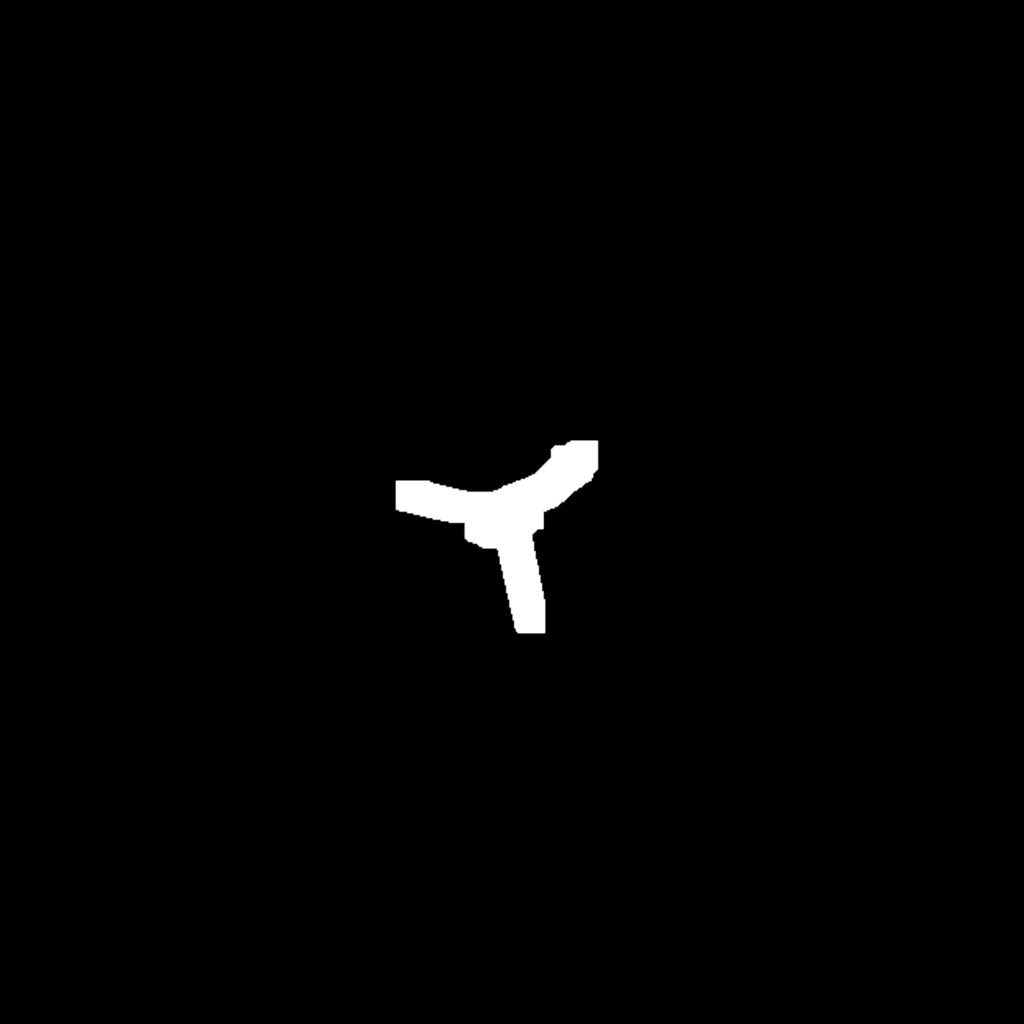

In [ ]:
from PIL import Image
init_image = Image.open('/content/d(1).jpg').resize((1024,1024))
mask_image = Image.open('/content/mask.png').resize((1024,1024))
mask_image

###B. For Multiple Images
Use this section if you want to run this code on multiple images within a loop

In [ ]:
input_folder = 'path/to/input/folder' #Add path of folder with all your images
output_folder = 'path/to/output/folder' #Add this for savepath of output images

In [ ]:
for image_file in os.listdir(input_folder):
  if image_file.lower().endswith(('.jpg', '.jpeg', '.png')):
    image_path = os.path.join(input_folder, image_file)
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    resized_image = cv2.resize(image, (640,640), interpolation = cv2.INTER_AREA)
    resized_image_PIL = Image.fromarray(resized_image.astype(np.uint8))
    mask = predict_img(net=net,
                        full_img=resized_image_PIL,
                        scale_factor=1,
                        out_threshold=0.3,
                        device=device)
    mask_result = mask_to_image(mask, mask_values)
    mask_result_resized = cv2.resize(np.array(mask_result , dtype=np.uint8) * 255, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC)

    # mask_result_resized is the mask you'll need to apply on the image. Add your code for generative fill from here on


# Concealer of Mask



In [ ]:
!pip install diffusers
!pip install transformers scipy ftfy accelerate
!pip install compel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.2 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0


In [ ]:
from diffusers import StableDiffusionInpaintPipeline
import torch
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    revision="fp16",
    torch_dtype=torch.float16,
).to('cuda')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

text_encoder/model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [ ]:
from compel import Compel

compel_proc = Compel(tokenizer=pipe.tokenizer, text_encoder=pipe.text_encoder)

  0%|          | 0/12 [00:00<?, ?it/s]

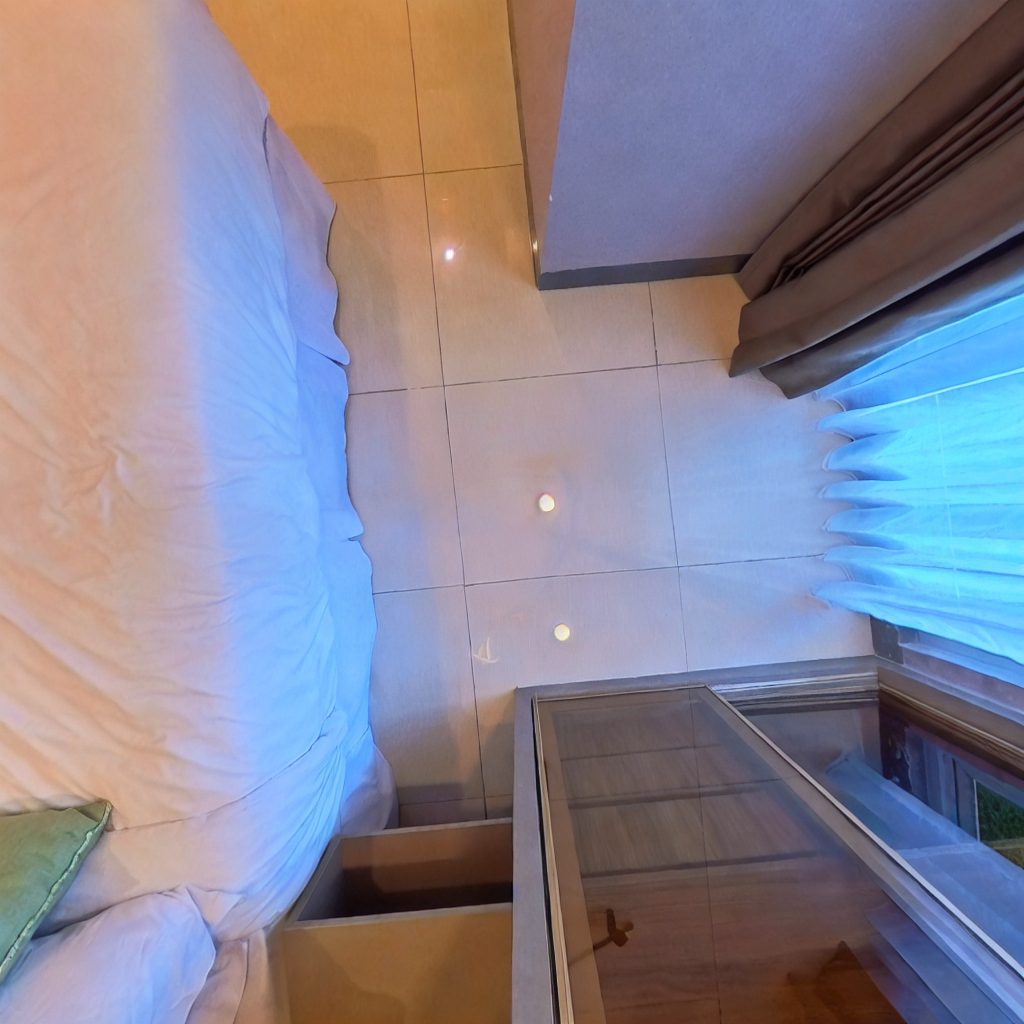

In [ ]:
prompt = "conceal++ floor++++, hide+++ object, bulb-- clean++++ floor,objects--, unclean----"
prompt_embeds = compel_proc(prompt)
negative_prompt = ''
generator = torch.Generator('cuda').manual_seed(54668765664675646)
#image and mask_image should be PIL images.
#The mask structure is white for inpainting and black for keeping as is
image = pipe(prompt_embeds=prompt_embeds,negative_prompt=negative_prompt, image=init_image, generator = generator, mask_image=mask_image, height = 1024, width = 1024, num_inference_steps = 12).images[0]
image